In [135]:
import numpy as np
import gf
import bch
import test_gf
import pandas as pd
import time
import matplotlib.pyplot as plt

## Реализация модуля gf

In [2]:
test_gf.test_primpoly()
test_gf.test_add()
test_gf.test_sum()
test_gf.test_prod()
test_gf.test_divide()
test_gf.test_linsolve()
test_gf.test_minpoly()
test_gf.test_polyval()
test_gf.test_polyprod()
test_gf.test_polydivmod()
test_gf.test_euclid()


Модуль gf был протестирован с помощью предоставленного файла test_gf. Немного изменил тесты: в тесте функции sum, у правильных выводов зачем-то добавлена фиктивная размерность,  она была убрана. Также при тестировании алгоритма Евклида дан ответ в случае если максимальаня степень остатка 2, а не 3, а также многочлены не нормализованны (есть незначащие нули в начале).

Как видно тестирование всех функций прошло успешно, и модуль gf работает корректно

## Реализация модуля bch

Реализованы все заялвенные процедуры: инициализация бчх-кода, кодирование, декодирование и вычиcление истинного минимального расстояния. В процесс инициализации были встроены проверки на то, что построенный порождающий многочлен является делителем многочлена $x^n - 1$ и то, что коэффиценты полинома равняются 0 или 1. При вычислении истинного расстояния делается проверка на то, что получившееся расстояние не меньше чем $2t + 1$. Таким образом, можно выполнить указанные проверки просто инициализировав код и посчитав расстояние (в случае ошибки будет AssertionError). Так и сделаем: 

In [18]:
code = bch.BCH(15, 5)
code.dist()
code = bch.BCH(15, 7)
code.dist()
code = bch.BCH(31, 5)
code.dist()
code = bch.BCH(31, 10)
code.dist()

31

Как видно, все инициализации и вычисления расстояний выполняются без ошибок

## БЧХ-код с расстоянием больше чем 2t + 1

Есть множество кодов, у которых истинное расстояние больше чем величина $2t + 1$, приведем несколько примеров:

In [21]:
print ('n =', 15)
print ('t =', 4)
print(bch.BCH(15, 4).dist())

n = 15
t = 4
15


In [23]:
print ('n =', 15)
print ('t =', 5)
print(bch.BCH(15, 5).dist())

n = 15
t = 5
15


In [25]:
print ('n =', 31)
print ('t =', 6)
print(bch.BCH(31, 6).dist())

n = 31
t = 6
15


## Статистические испытания

In [112]:
def check_answers(n, t, max_err):
    code = bch.BCH(n, t)
    num_mes = 500
    length = n - code.g.shape[0] + 1
    X = np.random.randint(2, size=(num_mes, length))
    U = code.encode(X)
    right = []
    wrong = []
    not_answer = []
    for t in range(1, max_err + 1):
        W = np.zeros_like(U, dtype=np.int64)
        for i in range(W.shape[0]):
            error = np.zeros(U.shape[1], dtype=np.int64)
            index = np.random.choice(n, t, replace=False)
            error[index] = 1
            W[i] = U[i] ^ error
        res = code.decode(W)
        right_count = 0
        wrong_count = 0
        not_answer_count = 0
        for i in range(W.shape[0]):
            if np.isnan(res[i][0]):
                not_answer_count += 1
                continue
            if (res[i] == U[i]).all():
                right_count += 1
            else:
                wrong_count += 1
        right.append(right_count)
        wrong.append(wrong_count)
        not_answer.append(not_answer_count)
    return np.array(right), np.array(wrong), np.array(not_answer)

Посмотрим как наш бчх-код декодирует при различных длине кода и максимальном количестве ошибок. Возьмем 500 слов и в каждом будем допускать сначала по 1 ошибке, потом по 2, и так до 15. И оценим долю правильно предсказанных слов, долю неправильных и долю тех, для который бчх-код отказался давать прогноз

In [113]:
right, wrong, not_answer = check_answers(15, 5, 15)

In [115]:
print('n = 15, t = 5')
pd.DataFrame([right/500, wrong/500, not_answer/500], columns=np.arange(1, 16),
            index=['Доля правильных', 'Доля неправильных', 'Доля непредсказанных'])

n = 15, t = 5


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Доля правильных,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Доля неправильных,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
Доля непредсказанных,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
right, wrong, not_answer = check_answers(31, 6, 15)

In [117]:
print('n = 31, t = 6')
pd.DataFrame([right/500, wrong/500, not_answer/500], columns=np.arange(1, 16),
            index=['Доля правильных', 'Доля неправильных', 'Доля непредсказанных'])

n = 31, t = 6


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Доля правильных,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000
Доля неправильных,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.014,0.014,0.028,0.038,0.014,0.034
Доля непредсказанных,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.99,0.986,0.986,0.972,0.962,0.986,0.966


In [118]:
right, wrong, not_answer = check_answers(31, 11, 15)

In [119]:
print('n = 31, t = 11')
pd.DataFrame([right/500, wrong/500, not_answer/500], columns=np.arange(1, 16),
            index=['Доля правильных', 'Доля неправильных', 'Доля непредсказанных'])

n = 31, t = 11


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Доля правильных,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Доля неправильных,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Доля непредсказанных,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [121]:
right, wrong, not_answer = check_answers(63, 10, 20)

In [123]:
print('n = 63, t = 10')
pd.DataFrame([right/500, wrong/500, not_answer/500], columns=np.arange(1, 21),
            index=['Доля правильных', 'Доля неправильных', 'Доля непредсказанных'])

n = 63, t = 10


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Доля правильных,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000
Доля неправильных,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002,0.0,0.008,0.0,0.002,0.0,0.004,0.008,0.006,0.004
Доля непредсказанных,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.998,1.0,0.992,1.0,0.998,1.0,0.996,0.992,0.994,0.996


Как видно, БЧХ-код успешно декодирует сообщения с числом ошибок <= t, но с большим числом ошибок, код не делает ни одного правильного предсказания: предсказание неверно, либо отказываетс предсказывать. В наших экспериментах при числе ошибок больше t, наш декодер чаще отказываться предсказывать, чем дает неправильный прогноз

## Сравнение методов декодирования Euclid и PGZ по времени работы

In [127]:
def check_time(n, t):
    code = bch.BCH(n, t)
    num_mes = 50
    length = n - code.g.shape[0] + 1
    X = np.random.randint(2, size=(num_mes, length))
    U = code.encode(X)
    W = np.zeros_like(U, dtype=np.int64)
    for i in range(W.shape[0]):
        error = np.zeros(U.shape[1], dtype=np.int64)
        index = np.random.choice(n, t, replace=False)
        error[index] = 1
        W[i] = U[i] ^ error
    time_dec = []
    time_start = time.time()
    res = code.decode(W)
    time_dec.append(time.time() - time_start)
    time_start = time.time()
    res = code.decode(W, method='pgz')
    time_dec.append(time.time() - time_start)
    return time_dec

Посчитаем время работы двух различных декодера при декодировке при различных длинах кода и максимальном числе ошибок t. Всего декодируется 50 сообщений, в каждом из которых допущено ровно t ошибок 

In [132]:
time_euclid = []
time_pgz = []
n_list = [15, 31, 63, 127, 255, 511]
t_list = [3, 5, 9, 11, 17, 23]
for i in range(len(n_list)):
    euc, pgz = check_time(n_list[i], t_list[i])
    time_euclid.append(euc)
    time_pgz.append(pgz)

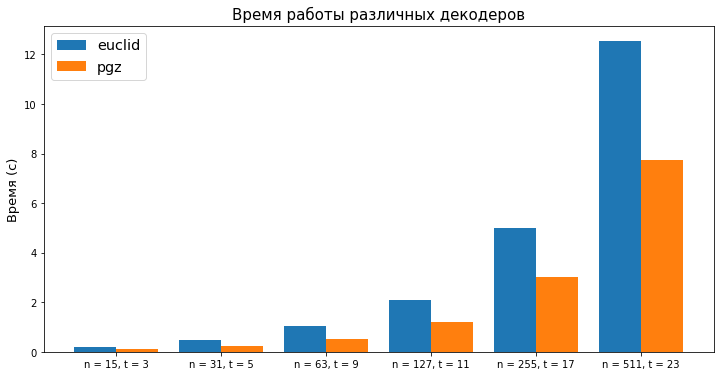

In [177]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
plt.bar(np.arange(6)-0.2, time_euclid, width=0.4)
plt.bar(np.arange(6)+0.2, time_pgz, width=0.4)
plt.title('Время работы различных декодеров', fontsize=15)
plt.ylabel('Время (с)', fontsize=13)
signatures = ['n = 15, t = 3', 'n = 31, t = 5', 'n = 63, t = 9',
             'n = 127, t = 11', 'n = 255, t = 17', 'n = 511, t = 23']
plt.xticks(np.arange(6), signatures)
plt.legend(['euclid', 'pgz'], loc=2, fontsize='x-large')
plt.show()

Как видно, pgz decoder в целом где-то в полтора раза быстрее декодера, основанного на расширенном алгоритме Евклида